<a href="https://colab.research.google.com/github/zinkin-s/homework/blob/main/Lab2_DL_part3_poetry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

--2025-04-23 14:51:57--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119748 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.002s  

2025-04-23 14:51:57 (47.6 MB/s) - ‘sonnets.txt’ saved [119748/119748]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [3]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2025-04-23 15:25:59--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.004s  

2025-04-23 15:25:59 (65.2 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
out = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(out))


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
token_to_idx = {token: idx for idx, token in enumerate(tokens)}
idx_to_token = {idx: char for char, idx in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [22]:
import torch
import torch.nn as nn
import random

num_tokens = len(token_to_idx)
seq_length = 100

def chunk_to_tensor(chunk):
    indices = [token_to_idx[letter] for letter in chunk]
    tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(1)
    one_hot_tensor = torch.nn.functional.one_hot(tensor, num_classes=num_tokens).float()
    return one_hot_tensor

def generate_chunk():
    start_index = random.randint(0, len(text) - seq_length - 1)
    end_index = start_index + seq_length + 1
    return out[start_index:end_index]

def training_set():
    chunk = generate_chunk()
    inp = chunk_to_tensor(chunk[:-1])
    target = torch.tensor([token_to_idx[letter] for letter in chunk[1:]], dtype=torch.long).unsqueeze(1)
    return inp, target

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size=1):
        return torch.zeros(batch_size, self.hidden_size, device=device)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_hidden = 128
rnn = CharRNN(num_tokens, n_hidden, num_tokens)
rnn.to(device)

criterion = nn.NLLLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

def train(inp, target):
    rnn.zero_grad()
    hidden = rnn.init_hidden().to(device)
    loss = 0

    for i in range(inp.size()[0]):
        output, hidden = rnn(inp[i].to(device), hidden)
        loss += criterion(output, target[i].to(device))

    loss.backward()
    optimizer.step()

    return output, loss.item() / seq_length

n_epochs = 10000
current_loss = 0
all_losses = []

# Проверка функции generate_chunk
chunk = generate_chunk()
print(f"Generated chunk: {chunk}")

for epoch in range(1, n_epochs + 1):
    inp, target = training_set()
    output, loss = train(inp, target)
    current_loss += loss

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} / {n_epochs}. Average Loss: {current_loss / 100:.4f}')
        all_losses.append(current_loss / 100)
        current_loss = 0

Generated chunk: народных слез, рукоплесканий
с младой семеновой делил;
там наш катенин воскресил
корнеля гений велича
Epoch: 100 / 10000. Average Loss: 4.1239
Epoch: 200 / 10000. Average Loss: 3.3338
Epoch: 300 / 10000. Average Loss: 3.1957
Epoch: 400 / 10000. Average Loss: 3.1411
Epoch: 500 / 10000. Average Loss: 3.0584
Epoch: 600 / 10000. Average Loss: 3.0171
Epoch: 700 / 10000. Average Loss: 2.9209
Epoch: 800 / 10000. Average Loss: 2.8370
Epoch: 900 / 10000. Average Loss: 2.7979
Epoch: 1000 / 10000. Average Loss: 2.7481
Epoch: 1100 / 10000. Average Loss: 2.6993
Epoch: 1200 / 10000. Average Loss: 2.6412
Epoch: 1300 / 10000. Average Loss: 2.6193
Epoch: 1400 / 10000. Average Loss: 2.5765
Epoch: 1500 / 10000. Average Loss: 2.5550
Epoch: 1600 / 10000. Average Loss: 2.5077
Epoch: 1700 / 10000. Average Loss: 2.5020
Epoch: 1800 / 10000. Average Loss: 2.4622
Epoch: 1900 / 10000. Average Loss: 2.4421
Epoch: 2000 / 10000. Average Loss: 2.4183
Epoch: 2100 / 10000. Average Loss: 2.3976
Epoch: 2

Plot the loss function (axis X: number of epochs, axis Y: loss function).

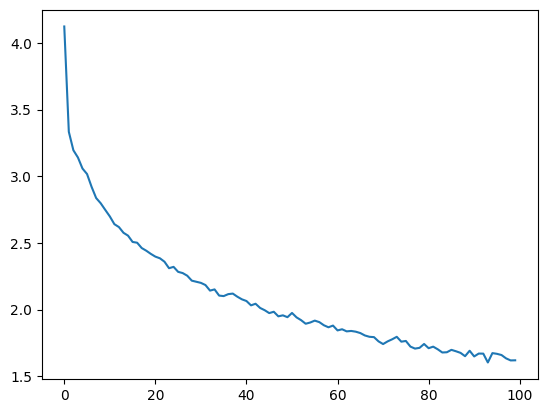

In [23]:
# Your plot code here
import matplotlib.pyplot as plt

plt.plot(all_losses)


In [ ]:
import torch.nn.functional as F
import numpy as np
def generate_sample(char_rnn, seed_phrase='wh', max_length=seq_length, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    #x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = chunk_to_tensor(seed_phrase)
    #hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape)
        out, hid_state = char_rnn(x_sequence[i].unsqueeze(0), None if i == 0 else hid_state)

    #start generating
    for i in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence)
        out, hid_state = char_rnn(x_sequence[i].unsqueeze(0))
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [29]:
def generate_text(model, temperature, seed_phrase, max_length=500):
    model.eval()
    hidden = model.init_hidden()
    result = seed_phrase
    input = chunk_to_tensor(seed_phrase).to(device)

    for _ in range(max_length):
        output, hidden = model(input[-1], hidden)
        output_dist = output.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = idx_to_token[top_i.item()]
        result += predicted_char
        input = chunk_to_tensor(result[-len(seed_phrase):]).to(device)

    return result

In [31]:
# An example of generated text.
print(generate_text(rnn, seed_phrase='мой дядя самых честных правил', max_length=500,temperature=0.5))

мой дядя самых честных правил в зовет,
и дыла де подлуго просбудеть воним,
чтобых раскузарнечной промужден себязья тери


м роско пось я зорат
и отчестын симер добыет, прознон коверизать прешук,
сек ой стристо натавись,
натов содений,
чео завости бружеть ерышолять,
полать перкек слетой,
треско казнак езен взонеть
и сяетя завалья храний сте сердата поспризать? стею зервенне порным, заворонью
себыть ятереник ка поревин,
что вопрани! когса сахор улчтять, шабогорок юбять я граждын


огоной нежеж попот; там,
чен ко промут белья 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [10]:
# Your beautiful code here
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size

        self.i2i = nn.Linear(input_size, hidden_size)
        self.h2i = nn.Linear(hidden_size, hidden_size)

        self.i2f = nn.Linear(input_size, hidden_size)
        self.h2f = nn.Linear(hidden_size, hidden_size)

        self.i2c = nn.Linear(input_size, hidden_size)
        self.h2c = nn.Linear(hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, hidden_size)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hx, cx = hidden
        ingate = self.sigmoid(self.i2i(input) + self.h2i(hx))
        forgetgate = self.sigmoid(self.i2f(input) + self.h2f(hx))
        cellgate = self.tanh(self.i2c(input) + self.h2c(hx))
        outgate = self.sigmoid(self.i2o(input) + self.h2o(hx))

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * self.tanh(cy)
        output = self.softmax(self.h2o(hy))
        return output, (hy, cy)

    def init_hidden(self, batch_size=1):
        return (torch.zeros(batch_size, self.hidden_size, device=device),
                torch.zeros(batch_size, self.hidden_size, device=device))

n_hidden = 128
lstm = LSTMCell(num_tokens, n_hidden)
lstm.to(device)

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

def lstm_train(inp, target):
    lstm.zero_grad()
    hidden = lstm.init_hidden()
    loss = 0

    for i in range(inp.size()[0]):
        output, hidden = lstm(inp[i].to(device), hidden)
        loss += criterion(output, target[i].to(device))

    loss.backward()
    optimizer.step()

    return output, loss.item() / seq_length

n_epochs = 10000
current_loss = 0
all_losses = []

# Проверка функции generate_chunk
chunk = generate_chunk()
print(f"Generated chunk: {chunk}")

for epoch in range(1, n_epochs + 1):
    inp, target = training_set()
    output, loss = lstm_train(inp, target)
    current_loss += loss

    if epoch % 100 == 0:
        print(f'Epoch: {epoch} / {n_epochs}. Average Loss: {current_loss / 100:.4f}')
        all_losses.append(current_loss / 10)
        current_loss = 0

Generated chunk: перва madame за ним ходила,
потом monsieur ее сменил;
ребенок был резов, но мил.
monsieur l’abbe€, фр
Epoch: 100 / 10000. Average Loss: 3.4157
Epoch: 200 / 10000. Average Loss: 3.0284
Epoch: 300 / 10000. Average Loss: 2.7820
Epoch: 400 / 10000. Average Loss: 2.7114
Epoch: 500 / 10000. Average Loss: 2.6092
Epoch: 600 / 10000. Average Loss: 2.5400
Epoch: 700 / 10000. Average Loss: 2.4842
Epoch: 800 / 10000. Average Loss: 2.4239
Epoch: 900 / 10000. Average Loss: 2.3650
Epoch: 1000 / 10000. Average Loss: 2.3225
Epoch: 1100 / 10000. Average Loss: 2.2897
Epoch: 1200 / 10000. Average Loss: 2.2366
Epoch: 1300 / 10000. Average Loss: 2.1781
Epoch: 1400 / 10000. Average Loss: 2.1524
Epoch: 1500 / 10000. Average Loss: 2.1472
Epoch: 1600 / 10000. Average Loss: 2.0894
Epoch: 1700 / 10000. Average Loss: 2.0456
Epoch: 1800 / 10000. Average Loss: 2.0095
Epoch: 1900 / 10000. Average Loss: 1.9667
Epoch: 2000 / 10000. Average Loss: 1.9374
Epoch: 2100 / 10000. Average Loss: 1.8803
Epoch: 2

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [28]:
# Text generation with different temperature values here
def generate_text(model, temperature, seed_phrase, max_length=500):
    model.eval()
    hidden = model.init_hidden()
    result = seed_phrase
    input = chunk_to_tensor(seed_phrase).to(device)

    for _ in range(max_length):
        output, hidden = model(input[-1], hidden)
        output_dist = output.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        predicted_char = idx_to_token[top_i.item()]
        result += predicted_char
        input = chunk_to_tensor(result[-len(seed_phrase):]).to(device)

    return result


print(generate_text(lstm, seed_phrase='мой дядя самых честных правил ', max_length=100,temperature=0.5))

мой дядя самых честных правил своей.



xix
тау продили свобой,
еду вы? мне имел охоты
в молга евгению мносбуть,
там белетых те на


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)